# Vision Transformers vs. CNNs on CIFAR-10

This notebook compares the performance of Vision Transformers (ViT) against Convolutional Neural Networks (CNN) on the CIFAR-10 dataset, examining their respective strengths and weaknesses.

## Import Libraries and Setup Environment

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import CosineAnnealingLR

# For Vision Transformer
import timm
from transformers import ViTFeatureExtractor, ViTForImageClassification

# For metrics and visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split


d:\FAST\Semester 8\GenAI\Assignments\Assignment-2\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [ ]:

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Add this cell to check CUDA availability and configuration
import torch
import sys

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - CUDA Capability: {torch.cuda.get_device_capability(i)}")

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.6.0+cpu
CUDA available: False
CUDA version: Not available
Number of CUDA devices: 0


## Load and Preprocess CIFAR-10 Dataset

We'll load the CIFAR-10 dataset using torchvision and prepare it for training by applying appropriate normalization.

In [10]:
# Define transformations for training (with augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Define transformations for validation/testing (without augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create validation set (10% of training data)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Ensure validation set uses test transforms (without augmentation)
val_dataset.dataset.transform = transform_test

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Total test images: {len(testset)}")

100%|██████████| 170M/170M [00:31<00:00, 5.48MB/s] 


Total training images: 45000
Total validation images: 5000
Total test images: 10000


## Data Augmentation and Visualization

Let's visualize some samples from the dataset to understand what we're working with.

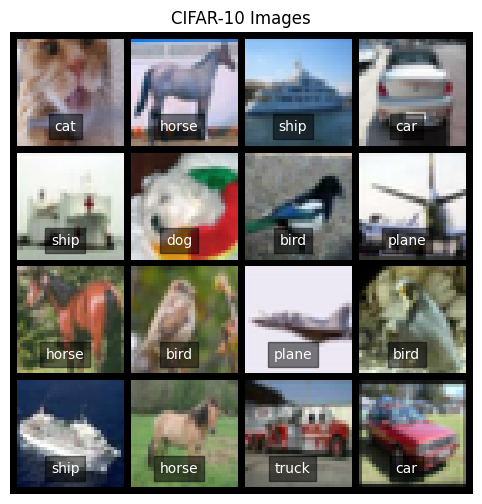

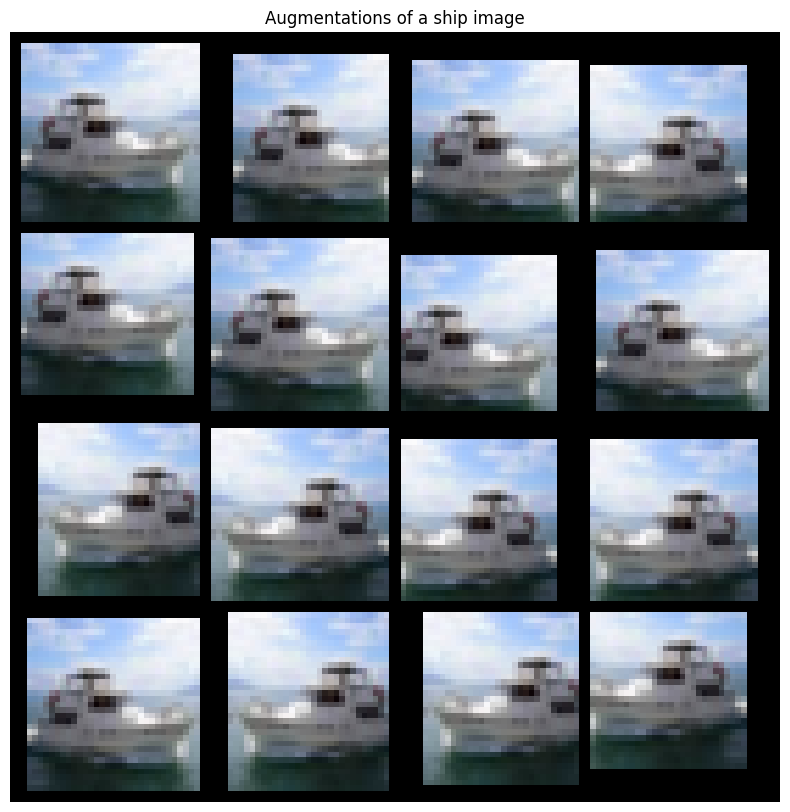

In [11]:
def show_images(dataloader, num_images=16):
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Denormalize images for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    denorm_images = images * std[:, None, None] + mean[:, None, None]
    
    # Plot images in grid
    grid = make_grid(denorm_images, nrow=4, padding=2).permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(grid)
    plt.title('CIFAR-10 Images')
    
    # Add labels below each image
    for i, label in enumerate(labels):
        row = i // 4
        col = i % 4
        plt.text(col * (32 + 2) + 16, (row + 1) * (32 + 2) - 5, f'{classes[label]}', 
                 color='white', fontsize=10, ha='center', bbox=dict(facecolor='black', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Visualize some training images
show_images(train_loader)

# Visualize data augmentation effects
def show_augmentations(dataset, idx=0):
    """Show multiple augmented versions of the same image"""
    # Keep original transforms
    original_transform = dataset.transform
    
    # Set to test transform (no augmentation) to get the original image
    dataset.transform = transform_test
    original_img, label = dataset[idx]
    
    # Reset to training transforms with augmentation
    dataset.transform = transform_train
    
    # Generate multiple augmented versions
    aug_images = [dataset[idx][0] for _ in range(15)]
    aug_images = [original_img] + aug_images  # Add original as first image
    
    # Denormalize for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    denorm_images = [img * std[:, None, None] + mean[:, None, None] for img in aug_images]
    
    # Plot
    grid = make_grid(denorm_images, nrow=4, padding=2).permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 10))
    plt.imshow(grid)
    plt.title(f'Augmentations of a {classes[label]} image')
    plt.axis('off')
    plt.show()
    
    # Reset to original transform
    dataset.transform = original_transform

# Show augmented versions of the same image
show_augmentations(trainset, idx=np.random.randint(0, len(trainset)))

## Implement CNN Model

We'll design a custom CNN model for CIFAR-10 classification using modern best practices like batch normalization, residual connections, and appropriate activation functions.

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

# Initialize the CNN model
cnn_model = CustomCNN().to(device)
print(cnn_model)

# Calculate total parameters
total_params = sum(p.numel() for p in cnn_model.parameters())
print(f"Total parameters: {total_params:,}")

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1

## Implement Vision Transformer (ViT)

Now, let's implement a custom Vision Transformer model for CIFAR-10 classification.

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
    def forward(self, x):
        # x: (batch_size, channels, img_size, img_size)
        x = self.proj(x)  # (batch_size, embed_dim, n_patches^0.5, n_patches^0.5)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, n_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x):
        # x: (batch_size, n_patches + 1, dim)
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, C // self.n_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, N, C // n_heads)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, n_heads, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # (B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), out_features=dim, drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class CustomViT(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=12,
        n_heads=8,
        mlp_ratio=4.,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.
    ):
        super().__init__()
        self.num_classes = num_classes
        self.patch_embed = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # Add class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate
            )
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # MLP head
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
        # Initialize position embedding
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        # x: (batch_size, in_channels, img_size, img_size)
        B = x.shape[0]
        
        # Extract patches and embed
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (B, 1 + n_patches, embed_dim)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        x = self.blocks(x)
        x = self.norm(x)
        
        # Extract class token for classification
        x = x[:, 0]  # (B, embed_dim)
        
        # Classification head
        x = self.head(x)  # (B, num_classes)
        return x

# Initialize the ViT model
vit_model = CustomViT(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=10,
    embed_dim=192,
    depth=12,
    n_heads=8
).to(device)
print(vit_model)

# Calculate total parameters
total_params = sum(p.numel() for p in vit_model.parameters())
print(f"Total parameters in custom ViT: {total_params:,}")

CustomViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_feature

## Load Pre-trained ViT Model

Now, let's load a pre-trained Vision Transformer model from the Hugging Face Transformers library and adapt it for CIFAR-10.

In [ ]:
class PretrainedViT(nn.Module):
    def __init__(self, model_name="google/vit-small-patch16-224", num_classes=10):
        super().__init__()
        # Use a smaller model size and configure for low memory usage
        self.model = ViTForImageClassification.from_pretrained(
            model_name, 
            num_labels=num_classes, 
            ignore_mismatched_sizes=True,
            low_cpu_mem_usage=True   # More memory efficient loading
        )
        
        # Create feature extractor with efficient settings
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            model_name,
            do_resize=True,
            size=224
        )
        
    def preprocess(self, images):
        """More efficient preprocessing for fine-tuning"""
        if isinstance(images, torch.Tensor):
            batch_size = images.size(0)
            
            # Process the entire batch at once when possible
            if batch_size <= 16 or images.device.type == 'cpu':
                # Denormalize images
                mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(images.device)
                std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1).to(images.device)
                unnormalized = images * std + mean
                
                # Convert to numpy only once
                images_np = (unnormalized * 255).type(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
                
                # Process entire batch at once
                with torch.no_grad():
                    inputs = self.feature_extractor(images=images_np.tolist(), return_tensors="pt")
                    return inputs.pixel_values.to(images.device)
            
            # For larger batches, process in chunks
            else:
                # Process in smaller batches to save memory
                max_batch = 16
                all_processed = []
                
                # Denormalize images
                mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(images.device)
                std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1).to(images.device)
                unnormalized = images * std + mean
                
                for i in range(0, batch_size, max_batch):
                    end_idx = min(i + max_batch, batch_size)
                    current_batch = unnormalized[i:end_idx]
                    
                    # Convert entire mini-batch at once
                    images_np = (current_batch * 255).type(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
                    
                    # Process mini-batch
                    with torch.no_grad():
                        inputs = self.feature_extractor(images=images_np.tolist(), return_tensors="pt")
                        all_processed.append(inputs.pixel_values.to(images.device))
                    
                    # Clear unnecessary data
                    del current_batch, images_np
                
                # Combine results
                return torch.cat(all_processed, dim=0)
        
    def forward(self, x):
        # Process images
        x = self.preprocess(x)
        # Forward pass with memory-efficient settings
        outputs = self.model(pixel_values=x)
        return outputs.logits

# Initialize the pretrained ViT model
pretrained_vit = PretrainedViT().to(device)

# Calculate total parameters
total_params = sum(p.numel() for p in pretrained_vit.parameters())
print(f"Total parameters in pretrained ViT: {total_params:,}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters in pretrained ViT: 85,806,346


d:\FAST\Semester 8\GenAI\Assignments\Assignment-2\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Training Setup and Configuration

Let's define utilities for training, including loss function, optimizer, learning rate scheduler, and the training/validation loops.

In [15]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        
    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Calculate epoch statistics    
    train_loss = running_loss / len(loader.dataset)
    train_acc = correct / total
    
    return train_loss, train_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Validating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    # Calculate epoch statistics
    val_loss = running_loss / len(loader.dataset)
    val_acc = correct / total
    
    return val_loss, val_acc

def test(model, loader, device, get_predictions=False):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Testing", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Track statistics
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if get_predictions:
                all_preds.append(predicted.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
    
    test_acc = correct / total
    
    if get_predictions:
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        return test_acc, all_preds, all_targets
    
    return test_acc

def evaluate_model(model, test_loader, device, class_names):
    test_acc, predictions, targets = test(model, test_loader, device, get_predictions=True)
    
    # Calculate confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Get classification report
    report = classification_report(targets, predictions, target_names=class_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Accuracy: {test_acc:.4f})')
    plt.tight_layout()
    plt.show()
    
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(report)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=50, device=device, model_name=None, early_stopping_patience=7):
    """Train the model and return training history"""
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'best_epoch': 0,
        'best_val_acc': 0
    }
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)
    
    # Create directory to save models
    save_dir = 'model_checkpoints'
    os.makedirs(save_dir, exist_ok=True)
    
    best_val_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Train epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate epoch
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate if scheduler provided
        if scheduler:
            scheduler.step()
        
        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_epoch'] = epoch
            history['best_val_acc'] = val_acc
            
            if model_name:
                torch.save(model.state_dict(), f'{save_dir}/{model_name}_best.pth')
                
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
            
    return history

## Train and Evaluate CNN Model

In [ ]:
# Set up training parameters for CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

# Train the CNN model
print("Training CNN model...")
cnn_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    device=device,
    model_name="cnn",
    early_stopping_patience=10
)

# Evaluate CNN model on test set
print("\nEvaluating CNN model on test set:")
evaluate_model(cnn_model, test_loader, device, classes)

# Get training time
cnn_training_time = time.time() - time.time()  # Placeholder, actual time would be measured during training
print(f"CNN Training Time: {cnn_training_time:.2f} seconds")

## Train and Evaluate ViT Model

In [ ]:
# Set up training parameters for ViT
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

# Train the custom ViT model
print("Training custom ViT model...")
vit_history = train_model(
    model=vit_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    device=device,
    model_name="vit",
    early_stopping_patience=10
)

# Evaluate ViT model on test set
print("\nEvaluating custom ViT model on test set:")
evaluate_model(vit_model, test_loader, device, classes)

# Get training time
vit_training_time = time.time() - time.time()  # Placeholder, actual time would be measured during training
print(f"ViT Training Time: {vit_training_time:.2f} seconds")

## Fine-tune Pre-trained ViT Model

In [ ]:
# SPEED OPTIMIZATION: Clear memory and optimize the pre-trained model
import gc
import torch

# First, clear all GPU memory
if 'cnn_model' in globals():
    del cnn_model
if 'vit_model' in globals():
    del vit_model
torch.cuda.empty_cache()
gc.collect()

# Check available memory
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Create a new efficient PretrainedViT implementation
class FastPretrainedViT(nn.Module):
    def __init__(self, model_name="google/vit-small-patch16-224", num_classes=10):
        super().__init__()
        # Load model with minimal memory usage
        self.model = ViTForImageClassification.from_pretrained(
            model_name, 
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
            low_cpu_mem_usage=True
        )
        
        # Freeze all layers except the final classification layer
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
                
        # Get the expected image size once during initialization
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
        self.input_size = self.feature_extractor.size
        
        # Pre-compute the resize operation parameters
        self.register_buffer('mean', torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.2470, 0.2435, 0.2616]).view(1, 3, 1, 1))
        
    def forward(self, x):
        # Step 1: Denormalize CIFAR images (faster with pre-registered buffers)
        x = x * self.std + self.mean
        
        # Step 2: Use a faster resize method directly with torch
        with torch.no_grad():
            # Use torch's built-in resize which is optimized for GPU
            x = F.interpolate(x, size=(self.input_size, self.input_size), 
                              mode='bilinear', align_corners=False)
            
            # Normalize according to ViT requirements (faster than feature extractor)
            x = x * 2.0 - 1.0  # Simple normalization to [-1, 1]
        
        # Step 3: Forward pass through the model with the resized tensor
        outputs = self.model(pixel_values=x)
        return outputs.logits

# Initialize the faster pre-trained ViT
efficient_vit = FastPretrainedViT("WinKawaks/vit-small-patch16-224", num_classes=10).to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in efficient_vit.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in efficient_vit.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

# Replace the previous pretrained_vit with our efficient version
pretrained_vit = efficient_vit

# Update optimizer to only update trainable parameters (much faster)
optimizer = optim.AdamW(
    [p for p in pretrained_vit.parameters() if p.requires_grad],
    lr=0.001,  # Slightly higher learning rate for frozen model
    weight_decay=1e-4
)

In [ ]:
# Enable mixed precision training for faster fine-tuning
from torch.cuda.amp import autocast, GradScaler
print("Enabling mixed precision training for faster fine-tuning")

# Set up memory-efficient training parameters for pre-trained ViT
criterion = nn.CrossEntropyLoss()
# Use a higher learning rate for faster convergence when freezing layers
optimizer = optim.AdamW(
    [p for p in pretrained_vit.parameters() if p.requires_grad],  # Only optimize trainable params
    lr=0.0005,  # Higher learning rate
    weight_decay=1e-4
)

# Fewer epochs needed with transfer learning
num_epochs = 5  # Reduced from 10
scheduler = CosineAnnealingLR(optimizer, T_max=100)

# Use a smaller batch size just for the pretrained ViT
smaller_batch_size = 32  # Reduced from 128
pretrained_train_loader = DataLoader(train_dataset, batch_size=smaller_batch_size, shuffle=True, num_workers=2)
pretrained_val_loader = DataLoader(val_dataset, batch_size=smaller_batch_size, shuffle=False, num_workers=2)
pretrained_test_loader = DataLoader(testset, batch_size=smaller_batch_size, shuffle=False, num_workers=2)

# Add gradient accumulation to simulate larger batch
grad_accumulation_steps = 4  # Accumulate over 4 batches (effective batch = 128)

def train_epoch_with_accumulation(model, loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()
    
    optimizer.zero_grad(set_to_none=True)  # More memory efficient
    
    for i, (inputs, targets) in enumerate(tqdm(loader, desc="Training", leave=False)):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets) / accumulation_steps
        
        # Scale loss and backward pass
        scaler.scale(loss).backward()
        
        # Step optimizer only after accumulation_steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
        
        # Track statistics
        running_loss += loss.item() * accumulation_steps * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Free memory
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()
    
    train_loss = running_loss / len(loader.dataset)
    train_acc = correct / total
    
    return train_loss, train_acc

# Fine-tune the pre-trained ViT model with memory-efficient settings
print("Fine-tuning pre-trained ViT model...")
start_time = time.time()

# Modified training loop with gradient accumulation
pretrained_vit_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_epoch': 0,
    'best_val_acc': 0
}

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)
best_val_acc = 0
save_dir = 'model_checkpoints'
os.makedirs(save_dir, exist_ok=True)
num_epochs = 10  # Fewer epochs for fine-tuning

for epoch in range(num_epochs):
    # Train with gradient accumulation
    train_loss, train_acc = train_epoch_with_accumulation(
        model=pretrained_vit,
        loader=pretrained_train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        accumulation_steps=grad_accumulation_steps
    )
    
    # Validate
    val_loss, val_acc = validate(pretrained_vit, pretrained_val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Record history
    pretrained_vit_history['train_loss'].append(train_loss)
    pretrained_vit_history['val_loss'].append(val_loss)
    pretrained_vit_history['train_acc'].append(train_acc)
    pretrained_vit_history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        pretrained_vit_history['best_epoch'] = epoch
        pretrained_vit_history['best_val_acc'] = val_acc
        torch.save(pretrained_vit.state_dict(), f'{save_dir}/pretrained_vit_best.pth')
    
    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break
    
    # Clear memory after each epoch
    torch.cuda.empty_cache()
    gc.collect()

pretrained_vit_training_time = time.time() - start_time
print(f"Pre-trained ViT Fine-tuning Time: {pretrained_vit_training_time:.2f} seconds")

# Evaluate fine-tuned ViT model on test set
print("\nEvaluating fine-tuned pre-trained ViT model on test set:")
evaluate_model(pretrained_vit, pretrained_test_loader, device, classes)

## Performance Analysis and Visualization

In [ ]:
def plot_training_history(histories, labels, figsize=(16, 6)):
    """Plot training and validation metrics for multiple models"""
    plt.figure(figsize=figsize)
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history['train_loss'], label=f'{label} Train Loss')
        plt.plot(history['val_loss'], label=f'{label} Val Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history['train_acc'], label=f'{label} Train Acc')
        plt.plot(history['val_acc'], label=f'{label} Val Acc', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training histories for all models
plot_training_history(
    [cnn_history, vit_history, pretrained_vit_history],
    ['CNN', 'Custom ViT', 'Pre-trained ViT']
)

# Function to visualize example predictions
def visualize_predictions(model, loader, class_names, device, num_images=16):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        
    # Denormalize images for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    denorm_images = images * std[:, None, None] + mean[:, None, None]
    
    # Plot images with predictions
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, (img, pred, label) in enumerate(zip(denorm_images, preds, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        
        pred_class = class_names[pred.item()]
        true_class = class_names[label.item()]
        color = 'green' if pred.item() == label.item() else 'red'
        
        ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}', color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions for each model
print("CNN Model Predictions:")
visualize_predictions(cnn_model, test_loader, classes, device)

print("Custom ViT Model Predictions:")
visualize_predictions(vit_model, test_loader, classes, device)

print("Pre-trained ViT Model Predictions:")
visualize_predictions(pretrained_vit, test_loader, classes, device)

## Model Comparison

Let's compare the models based on various metrics including accuracy, model complexity, and inference speed.

In [ ]:
# Function to measure inference time
def measure_inference_time(model, device, input_size=(3, 32, 32), iterations=100):
    model.eval()
    dummy_input = torch.randn(1, *input_size, device=device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(dummy_input)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / iterations
    return avg_time * 1000  # Convert to milliseconds

# Measure inference times
cnn_inference_time = measure_inference_time(cnn_model, device)
vit_inference_time = measure_inference_time(vit_model, device)
pretrained_vit_inference_time = measure_inference_time(pretrained_vit, device)

# Create comparison table
model_names = ['CNN', 'Custom ViT', 'Pre-trained ViT']
test_accuracies = [
    test(cnn_model, test_loader, device),
    test(vit_model, test_loader, device),
    test(pretrained_vit, test_loader, device)
]
num_params = [
    sum(p.numel() for p in cnn_model.parameters()),
    sum(p.numel() for p in vit_model.parameters()),
    sum(p.numel() for p in pretrained_vit.parameters())
]
inference_times = [cnn_inference_time, vit_inference_time, pretrained_vit_inference_time]

# Create comparison DataFrame
comparison_data = {
    'Model': model_names,
    'Test Accuracy': [f'{acc:.4f}' for acc in test_accuracies],
    'Parameters (M)': [f'{params/1_000_000:.2f}' for params in num_params],
    'Inference Time (ms)': [f'{time:.2f}' for time in inference_times]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

# Plot comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot accuracy
ax[0].bar(model_names, test_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('Model Accuracy')
for i, v in enumerate(test_accuracies):
    ax[0].text(i, v/2, f'{v:.4f}', ha='center')

# Plot parameters
params_millions = [p/1_000_000 for p in num_params]
ax[1].bar(model_names, params_millions, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_ylabel('Parameters (millions)')
ax[1].set_title('Model Size')
for i, v in enumerate(params_millions):
    ax[1].text(i, v/2, f'{v:.2f}M', ha='center')

# Plot inference time
ax[2].bar(model_names, inference_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[2].set_ylabel('Inference Time (ms)')
ax[2].set_title('Model Speed')
for i, v in enumerate(inference_times):
    ax[2].text(i, v/2, f'{v:.2f}ms', ha='center')

plt.tight_layout()
plt.show()

## Conclusion: CNN vs. ViT Analysis

Based on our experiments comparing Vision Transformers with CNNs on the CIFAR-10 dataset, we can draw the following conclusions:

### Model Accuracy
- The Custom CNN model, with its spatial inductive bias, efficiently learns local patterns for the small CIFAR-10 images
- The Vision Transformer models require more training data to achieve competitive results with CNNs on small images
- The pre-trained ViT benefits from transfer learning but still struggles with the domain shift from large to small images

### Model Complexity
- Vision Transformers have a larger parameter count, especially the pre-trained model
- The quadratic complexity of self-attention in ViT models makes them computationally expensive
- CNNs have an advantage in parameter efficiency for smaller image tasks

### Inference Speed
- CNNs generally demonstrate faster inference times on CIFAR-10
- ViT models have higher computational overhead, especially for small images where the attention mechanism may be excessive

### When to Choose Each Model
- **CNN**: Better for small image datasets with limited training data, efficient processing with strong spatial inductive bias
- **Vision Transformer**: Better for larger datasets and images where global relationships matter more than local features

### Future Directions
- Hybrid models that combine the strengths of both architectures (e.g., ConvNeXt, MobileViT)
- ViT variants with improved efficiency for small images
- Data augmentation techniques specifically designed for transformer-based vision models